In [2]:
import numpy as np
from pylab import *
from scipy import ndimage
from scipy import misc
import os
import glob
import h5py as h5
import re

import matplotlib.animation as anim

import time
from progress import ProgressBar, query_yes_no

%matplotlib inline
rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

# Load an image 

In [3]:
filedir = 'rawdata/Danio_17_recon/Danio_17_stained_recon'
files = glob.glob(os.path.join(filedir,'*rec[0-9][0-9][0-9][0-9].tif'))
files = sorted(files)

In [4]:
frames = [535, 1560]

In [5]:
prog = re.compile('rec(\d{4})\.tif')
filenum = []
for fn in files:
    res = prog.search(fn)
    filenum.append(int(res.group(1)))

In [6]:
files = [fn for fn,num in zip(files,filenum) if num >= frames[0] and num <= frames[1]]

In [7]:
len(files)

1026

In [8]:
print files[0]
print files[-1]

rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0535.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec1560.tif


(2240, 2240)


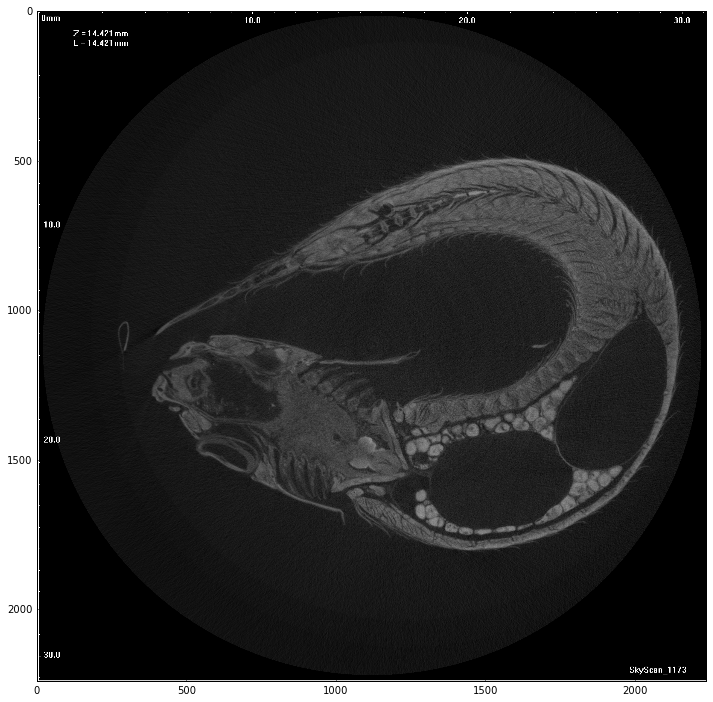

In [10]:
I = misc.imread(files[500])
imshow(I, cmap=cm.gray)
print I.shape
show()

Crop the image.

Crop is y coordinate, then x.

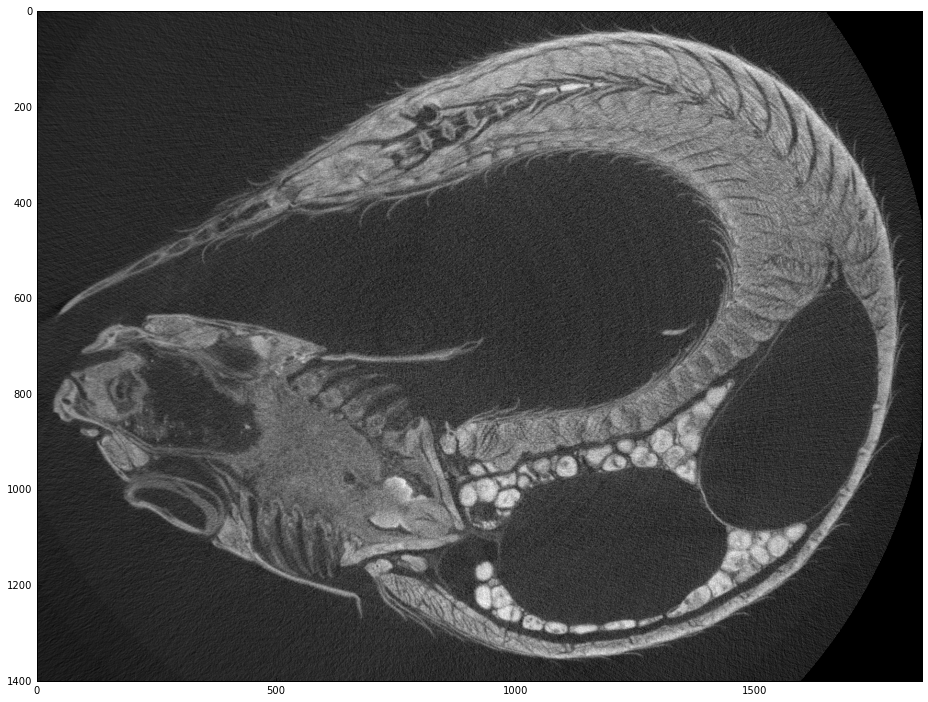

In [17]:
crop = (slice(450,1850),slice(350,2200))
imshow(I[crop], cmap=cm.gray)
show()

## Check crop on other images

rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0595.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0656.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0716.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0776.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0836.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0897.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec0957.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec1017.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec1078.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec1138.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec1198.tif
rawdata/Danio_17_recon/Danio_17_stained_recon/Danio_16_17_PMA_scan2_rec1259.tif
rawdata/Danio_17_recon/Danio_17_stained_

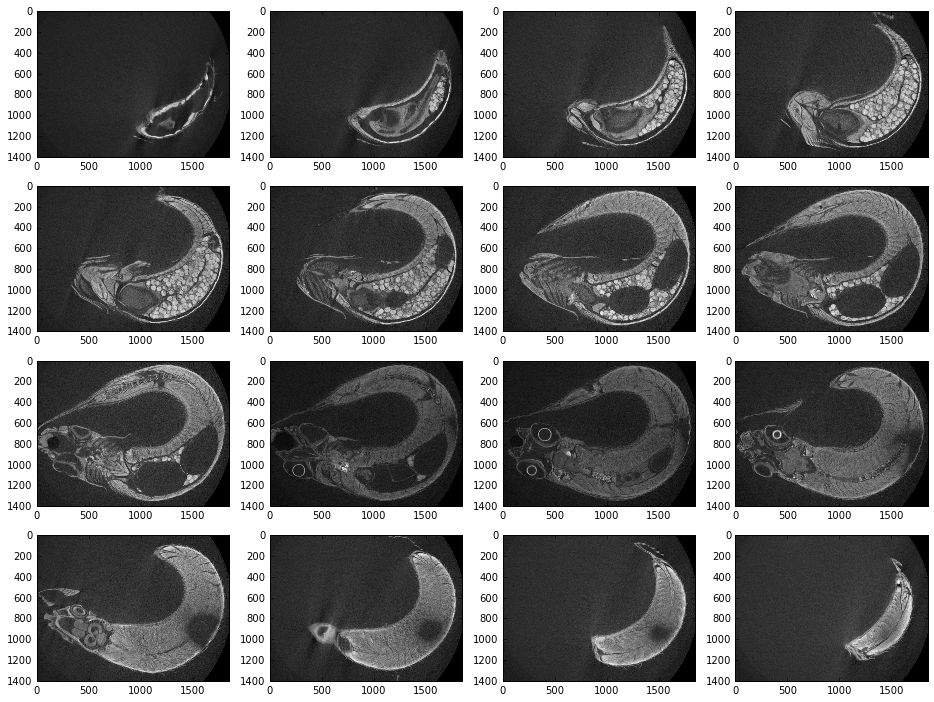

In [18]:
fig,ax = subplots(4,4)
r = np.linspace(0,len(files)-1,18)
r = r[1:-1]
for ax,f in zip(ax.flat, r):
    print files[int(round(f))]
    I1 = misc.imread(files[int(round(f))])
    ax.imshow(I1[crop], cmap=cm.gray)
show()         

# Set up the file

In [20]:
outfile = 'Fish17.h5'
pixelsize = 13.928416           # um

## Make the image dataset

Warning!  This can take a long time

In [21]:
if not os.path.exists(outfile) or query_yes_no('Overwrite existing file?',default='no'):
    f = h5.File(outfile,'w-')
    
    imsz = list(I[crop].shape) + [len(files)]
    chunksz = (32,32,32)
    imgdata = f.create_dataset('image',imsz, chunks=chunksz, dtype=I.dtype)
    imgdata.attrs['PixelSize_um'] = pixelsize

    with ProgressBar(total=len(files)) as prog:
        for (i,filename) in enumerate(files):
            I1 = misc.imread(files[i])
            imgdata[:,:,i] = I1[crop]
            prog.update(1)
    f.close()

[-----------------------------------------------------------> ] 100%  15m 29sec elapsed, 0sec remaining


# Make some animations

In [15]:
%matplotlib qt

In [16]:
imgfile = h5.File(outfile,'r')
imgdata = imgfile['image']
print imgdata.shape

(1000, 1000, 552)


In [17]:
frames = np.linspace(0,imgdata.shape[0],18)
frames = frames[1:-1]
for fr in frames:
    print "{}: [{},{}]".format(fr, np.min(imgdata[fr,:,:]), np.max(imgdata[fr,:,:]))

58.8235294118: [0,53420]
117.647058824: [0,61526]
176.470588235: [0,65535]
235.294117647: [0,65535]
294.117647059: [0,65535]
352.941176471: [0,60493]
411.764705882: [0,60640]
470.588235294: [0,65535]
529.411764706: [0,60236]
588.235294118: [0,62380]
647.058823529: [0,65535]
705.882352941: [0,65535]
764.705882353: [0,65535]
823.529411765: [0,65535]
882.352941176: [0,65535]
941.176470588: [0,65535]


In [18]:
dpi = 96

In [19]:
def show_yz_slice(num, data, im):
    im.set_data(data[num,:,:].T)
    return im,

In [20]:
%matplotlib qt

fig = figure(frameon=False)
fig.set_size_inches(imgdata.shape[1]/dpi, imgdata.shape[2]/dpi)

ax = axes([0., 0., 1., 1.])
im = ax.imshow(imgdata[0,:,:].T, cmap=cm.gray, vmin=0, vmax=65000)

im_ani = anim.FuncAnimation(fig, show_yz_slice, frames=imgdata.shape[0], fargs=(imgdata, im), interval=50)
show()

In [21]:
writer = anim.writers['ffmpeg'](fps=10, metadata=dict(artist='Eric Tytell'), bitrate=1800)

In [22]:
moviefile = 'Drerio_7yz.mp4'

if not os.path.exists(moviefile):
    im_ani.save(moviefile, writer=writer)
else:
    print "File already exists!"